In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/working/check_point'):
    for filename in filenames:
        os.remove(os.path.join(dirname, filename))

In [1]:
pip install thop

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn.functional import cross_entropy
import os
from thop import profile
import pandas as pd
import glob
import math
import torch.optim.lr_scheduler as lr_scheduler
import sys

# 配置运行设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 设置参数
batch_size = 32
learning_rate = 0.00003
num_epoch = 70
model_name = 'basenet'

In [3]:
torch.__version__

'1.13.0'

In [4]:
# 数据处理
normalize = transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    normalize
])

# 读取图像数据
train_dataset = ImageFolder('/kaggle/input/breakhis-total-dataset/train/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ImageFolder('/kaggle/input/breakhis-total-dataset/test/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('{0} for train. {1} for val'.format(len(train_dataset), len(test_dataset)))

8486 for train. 2122 for val


In [5]:
device

device(type='cuda')

In [6]:
class Basenet(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        input_shape: [B, 3, 224, 224]

        '''
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv_layer1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)
        self.conv_layer2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv_layer4 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv_layer5 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_layer6 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.inception = nn.Conv2d(32, 128, 3, stride=1, padding=1)
        self.conv_layer_res = nn.Conv2d(128, 128, 3, stride=1, padding=1)

        
        self.relu = nn.ReLU(inplace=True)
        self.adptavgpool2d = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512, 2, bias=True)
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

    def forward(self, x):
        """
        args:
            x: Input img, (B, 3, 224, 224)
        return:
            the calss capsules, ench capsule is a 16 dimension vector

        """
        x = self.relu(self.conv_layer1(x))  # [B, 16, 224, 224]
        x = self.maxpool(x)# [B, 16, 112, 112]
        x = self.relu(self.conv_layer2(x))
        y = self.maxpool(x)# [B, 32, 56, 56]
        
        
        x = self.relu(self.conv_layer3(y))
        x = self.maxpool(x) # [B, 64, 28, 28]
        x = self.conv_layer4(x) # [B, 128, 28, 28]
        
        y = self.inception(y) # [B, 128, 56, 56]
        y = self.maxpool(self.conv_layer_res(y)) # [B, 128, 28, 28]
        
        x = self.relu(x + y)
        x = self.maxpool(x) # [B, 128, 14, 14]
        x = self.relu(self.conv_layer5(x)) # [B, 256, 14, 14]
        x = self.maxpool(x)
        x = self.relu(self.conv_layer6(x)) # [B, 512, 7, 7]
        
        x = self.adptavgpool2d(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [7]:
save_path = '/kaggle/working/check_point'
if not os.path.exists(save_path):
    os.mkdir(save_path)
result_path = os.path.join('/kaggle/working/check_point', model_name)
if not os.path.exists(result_path):
    print(1)
    os.mkdir(result_path)
if len(glob.glob(result_path + '/**.pth')) == 0:
    model = Basenet()
    fc_in_features = model.fc.in_features
    model.fc = torch.nn.Linear(fc_in_features, 2, bias=True)
else:
    model_path = glob.glob(result_path + '/**.pth')[-1]
    model = torch.load(model_path)
    

train_test_data_path = os.path.join(result_path, 'train_test_data.csv')
if os.path.exists(train_test_data_path):
    train_test_data = pd.read_csv(train_test_data_path)
    last_epoch = train_test_data.shape[0]
    test_acc_best = train_test_data['test_acc_best'].values[-1]
else:
    train_test_data = pd.DataFrame(data=[], columns=['train_acc', 'train_loss',
                                                     'train_lr',
                                                     'test_acc', 'test_loss', 
                                                     'epoch', 'test_acc_best'])
    last_epoch = 0
    test_acc_best = 0
assert num_epoch > last_epoch, '已达训练次数'

In [8]:
model = model.to(device)
# 输出模型参数与模型计算量

flops, params = profile(model, inputs=(torch.zeros((batch_size, 3, 224, 224)).to(device),), verbose=False)
print(f'number of parameter: {params}', ', %.1f GFLOPS' % (flops / 1E9 * 2))

def get_parameter_number(model):
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters()if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}
print(get_parameter_number(model))

number of parameter: 1759138.0 , 59.3 GFLOPS
{'Total': 1759138, 'Trainable': 1759138}


epoch[10] time[223.9]s lr:5e-05
Accuracy on train set: 83.42%  eval_loss:0.36655137793455317
Accuracy on test set: 83.93%  eval_loss:0.3635552724951511


epoch[11] time[128.4]s lr:5e-05
Accuracy on train set: 83.35%  eval_loss:0.3629819457890036
Accuracy on test set: 83.32%  eval_loss:0.3596870456519383


epoch[12] time[127.7]s lr:5e-05
Accuracy on train set: 87.26%  eval_loss:0.2926089935585937
Accuracy on test set: 87.18%  eval_loss:0.28510666107030325


epoch[13] time[128.0]s lr:5e-05
Accuracy on train set: 86.13%  eval_loss:0.32611081324607283
Accuracy on test set: 86.15%  eval_loss:0.3292041294536537


epoch[14] time[128.3]s lr:5e-05
Accuracy on train set: 87.84%  eval_loss:0.28929778112433524
Accuracy on test set: 88.22%  eval_loss:0.2789884083232826


epoch[15] time[127.0]s lr:5e-05
Accuracy on train set: 88.72%  eval_loss:0.27053758720449195
Accuracy on test set: 88.69%  eval_loss:0.27053729146297645


epoch[16] time[127.2]s lr:5e-05
Accuracy on train set: 86.88%  eval_loss:0.31395214791851955
Accuracy on test set: 87.37%  eval_loss:0.30285296318780464


epoch[17] time[126.8]s lr:5e-05
Accuracy on train set: 88.49%  eval_loss:0.26483769539586505
Accuracy on test set: 88.45%  eval_loss:0.2696617429937314


epoch[18] time[126.9]s lr:5e-05
Accuracy on train set: 90.47%  eval_loss:0.24189850091653248
Accuracy on test set: 90.25%  eval_loss:0.24343287130215616


epoch[19] time[126.6]s lr:5e-05
Accuracy on train set: 89.56%  eval_loss:0.27154593430626317
Accuracy on test set: 88.69%  eval_loss:0.28081351513013203


epoch[20] time[129.4]s lr:5e-05
Accuracy on train set: 89.05%  eval_loss:0.26316829585197427
Accuracy on test set: 88.31%  eval_loss:0.2733875482178993


epoch[21] time[127.5]s lr:5e-05
Accuracy on train set: 91.01%  eval_loss:0.22496981163393515
Accuracy on test set: 89.73%  eval_loss:0.2238964171032092


epoch[22] time[127.1]s lr:5e-05
Accuracy on train set: 88.29%  eval_loss:0.28224863793113564
Accuracy on test set: 87.51%  eval_loss:0.2850413646594631


epoch[23] time[126.4]s lr:5e-05
Accuracy on train set: 90.28%  eval_loss:0.22329332392409026
Accuracy on test set: 89.87%  eval_loss:0.22910705607640755


epoch[24] time[126.5]s lr:5e-05
Accuracy on train set: 90.3%  eval_loss:0.24027821831115428
Accuracy on test set: 89.3%  eval_loss:0.2585674670369528


epoch[25] time[126.3]s lr:5e-05
Accuracy on train set: 90.82%  eval_loss:0.2305483950875768
Accuracy on test set: 90.01%  eval_loss:0.23414342039379726


epoch[26] time[126.2]s lr:5e-05
Accuracy on train set: 91.62%  eval_loss:0.2035130911205783
Accuracy on test set: 91.14%  eval_loss:0.2112396154956476


epoch[27] time[126.6]s lr:5e-05
Accuracy on train set: 91.59%  eval_loss:0.21217039245045358
Accuracy on test set: 91.42%  eval_loss:0.21487191580692402


epoch[28] time[127.3]s lr:5e-05
Accuracy on train set: 92.22%  eval_loss:0.18859665574483536
Accuracy on test set: 91.94%  eval_loss:0.19737015653341924


epoch[29] time[126.6]s lr:5e-05
Accuracy on train set: 91.7%  eval_loss:0.1984199667746746
Accuracy on test set: 90.95%  eval_loss:0.20954949365934036


epoch[30] time[126.5]s lr:5e-05
Accuracy on train set: 92.84%  eval_loss:0.18570492402748093
Accuracy on test set: 91.28%  eval_loss:0.20042993992033373


epoch[31] time[126.3]s lr:5e-05
Accuracy on train set: 88.45%  eval_loss:0.27438412231289777
Accuracy on test set: 87.89%  eval_loss:0.2906320197586739


epoch[32] time[126.5]s lr:5e-05
Accuracy on train set: 93.13%  eval_loss:0.17066176905753955
Accuracy on test set: 92.51%  eval_loss:0.18211637544081416


epoch[33] time[126.3]s lr:5e-05
Accuracy on train set: 93.53%  eval_loss:0.16165429334749515
Accuracy on test set: 92.65%  eval_loss:0.17530908571112055


epoch[34] time[126.9]s lr:5e-05
Accuracy on train set: 93.47%  eval_loss:0.16206028924751417
Accuracy on test set: 92.93%  eval_loss:0.16625506865540055


epoch[35] time[126.5]s lr:5e-05
Accuracy on train set: 93.54%  eval_loss:0.1548181632667562
Accuracy on test set: 94.49%  eval_loss:0.16491676112821257


epoch[36] time[126.6]s lr:5e-05
Accuracy on train set: 93.79%  eval_loss:0.1594500448971797
Accuracy on test set: 93.64%  eval_loss:0.17465235269035964


epoch[37] time[126.6]s lr:5e-05
Accuracy on train set: 94.1%  eval_loss:0.14685788600513067
Accuracy on test set: 93.07%  eval_loss:0.16996178876443588


epoch[38] time[126.9]s lr:5e-05
Accuracy on train set: 92.51%  eval_loss:0.19693943377010895
Accuracy on test set: 91.33%  eval_loss:0.21098842576469148


epoch[39] time[126.9]s lr:5e-05
Accuracy on train set: 94.34%  eval_loss:0.15281733052224278
Accuracy on test set: 92.93%  eval_loss:0.1701211340016177


epoch[40] time[126.4]s lr:5e-05
Accuracy on train set: 93.71%  eval_loss:0.16508478303261026
Accuracy on test set: 91.94%  eval_loss:0.18690614209885198


epoch[41] time[127.2]s lr:5e-05
Accuracy on train set: 94.87%  eval_loss:0.1297354141644029
Accuracy on test set: 94.06%  eval_loss:0.14474896226397782


epoch[42] time[126.6]s lr:5e-05
Accuracy on train set: 94.85%  eval_loss:0.12978436829991535
Accuracy on test set: 93.92%  eval_loss:0.15106831819633623


epoch[43] time[126.7]s lr:5e-05
Accuracy on train set: 94.54%  eval_loss:0.13857481054629803
Accuracy on test set: 94.16%  eval_loss:0.1538688547200015


epoch[44] time[126.4]s lr:5e-05
Accuracy on train set: 93.6%  eval_loss:0.16630710163067006
Accuracy on test set: 91.89%  eval_loss:0.19340996468100877


epoch[45] time[126.3]s lr:5e-05
Accuracy on train set: 95.53%  eval_loss:0.1159535953030956
Accuracy on test set: 94.63%  eval_loss:0.14319775376423252


epoch[46] time[125.7]s lr:5e-05
Accuracy on train set: 94.6%  eval_loss:0.13777478857897882
Accuracy on test set: 93.54%  eval_loss:0.15360969765696406


epoch[47] time[127.6]s lr:5e-05
Accuracy on train set: 94.94%  eval_loss:0.13112070615311824
Accuracy on test set: 93.83%  eval_loss:0.160387033679146


epoch[48] time[126.6]s lr:5e-05
Accuracy on train set: 89.7%  eval_loss:0.23260191252229911
Accuracy on test set: 87.84%  eval_loss:0.28045121192033284


epoch[49] time[126.5]s lr:5e-05
Accuracy on train set: 95.56%  eval_loss:0.11452075395835842
Accuracy on test set: 94.44%  eval_loss:0.133453527646285


epoch[50] time[126.8]s lr:5e-05
Accuracy on train set: 91.48%  eval_loss:0.20686547181606574
Accuracy on test set: 89.63%  eval_loss:0.23925121357483645


epoch[51] time[126.5]s lr:5e-05
Accuracy on train set: 96.12%  eval_loss:0.10504478876415975
Accuracy on test set: 94.72%  eval_loss:0.13136060323836554


epoch[52] time[126.1]s lr:5e-05
Accuracy on train set: 94.01%  eval_loss:0.15454656364779895
Accuracy on test set: 92.84%  eval_loss:0.17955563206868166


epoch[53] time[126.3]s lr:5e-05
Accuracy on train set: 95.38%  eval_loss:0.11407813563286176
Accuracy on test set: 94.77%  eval_loss:0.14570384037932846


epoch[54] time[126.8]s lr:5e-05
Accuracy on train set: 96.05%  eval_loss:0.10367945140399322
Accuracy on test set: 94.82%  eval_loss:0.13062348726585607


epoch[55] time[126.8]s lr:5e-05
Accuracy on train set: 95.18%  eval_loss:0.1222579878946534
Accuracy on test set: 94.3%  eval_loss:0.15312992268076042


epoch[56] time[127.2]s lr:5e-05
Accuracy on train set: 95.22%  eval_loss:0.12313857621568401
Accuracy on test set: 93.54%  eval_loss:0.15009569574031595


epoch[57] time[127.3]s lr:5e-05
Accuracy on train set: 96.25%  eval_loss:0.10122465775481042
Accuracy on test set: 95.0%  eval_loss:0.13670578846158452


epoch[58] time[127.3]s lr:5e-05
Accuracy on train set: 95.2%  eval_loss:0.11803638441661549
Accuracy on test set: 94.2%  eval_loss:0.1493117251730999


epoch[59] time[127.5]s lr:5e-05
Accuracy on train set: 96.85%  eval_loss:0.08913987101655566
Accuracy on test set: 95.1%  eval_loss:0.11905781170537627


epoch[60] time[127.4]s lr:5e-05
Accuracy on train set: 95.56%  eval_loss:0.11304561071924912
Accuracy on test set: 93.4%  eval_loss:0.15297124191458555


epoch[61] time[127.7]s lr:5e-05
Accuracy on train set: 95.36%  eval_loss:0.11879166270971242
Accuracy on test set: 93.5%  eval_loss:0.14702825288970328


epoch[62] time[127.4]s lr:5e-05
Accuracy on train set: 92.14%  eval_loss:0.17942396773413025
Accuracy on test set: 92.51%  eval_loss:0.21328480868941765


epoch[63] time[130.7]s lr:5e-05
Accuracy on train set: 94.91%  eval_loss:0.13001211228399184
Accuracy on test set: 93.45%  eval_loss:0.16033254273088332


epoch[64] time[126.9]s lr:5e-05
Accuracy on train set: 96.52%  eval_loss:0.08912130640505789
Accuracy on test set: 95.19%  eval_loss:0.12476520643382562


epoch[65] time[127.7]s lr:5e-05
Accuracy on train set: 95.99%  eval_loss:0.10532818281956785
Accuracy on test set: 94.16%  eval_loss:0.14395699368457993


epoch[66] time[126.9]s lr:5e-05
Accuracy on train set: 94.01%  eval_loss:0.168759727580576
Accuracy on test set: 92.6%  eval_loss:0.20885842979572272


epoch[67] time[126.9]s lr:5e-05
Accuracy on train set: 95.04%  eval_loss:0.1278197416263511
Accuracy on test set: 93.03%  eval_loss:0.18080982821488809


epoch[68] time[126.8]s lr:5e-05
Accuracy on train set: 95.33%  eval_loss:0.11306793861672362
Accuracy on test set: 93.36%  eval_loss:0.16314843367226947


epoch[69] time[128.5]s lr:5e-05
Accuracy on train set: 95.17%  eval_loss:0.11870106893863538
Accuracy on test set: 94.63%  eval_loss:0.1667495112195541


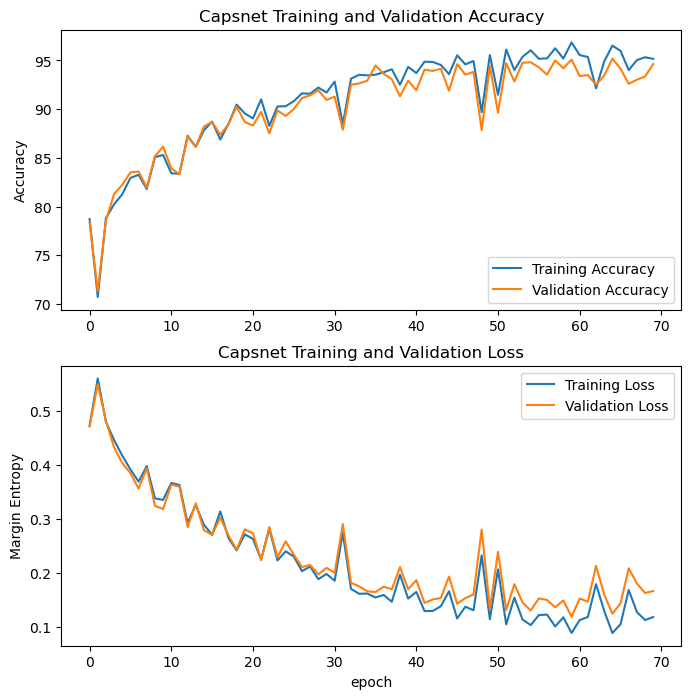

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')


def train(epoch, dataloder):
    model.train()

    t0 = time.time()
    for (X_batch, y_batch) in tqdm(dataloder, leave=False, desc=f'epoch:{epoch}'):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        out_put = model(X_batch)
        loss = loss_fn(out_put, y_batch)
        loss.backward()
        optimizer.step()
    now_lr = optimizer.param_groups[0]["lr"]
#     scheduler.step()
    t1 = time.time()
    print(f'epoch[{epoch}] time[{round(t1 - t0, 1)}]s lr:{now_lr}')
    return now_lr

def evaluate(data_loader, type):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        eval_loss = 0
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(F.softmax(outputs, dim=-1), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            eval_loss += loss_fn(outputs, labels).item()
    acc = 100 * correct / total
    print(f'Accuracy on {type} set: {round(acc, 2)}%  eval_loss:{eval_loss / total}')
    return acc, eval_loss / total


'''
每次运行之后要保存：
1.模型本身
2.模型迭代次数
3.模型学习率
4.历代模型表现情况loss,acc等

'''


if __name__ == '__main__':
    weight_path_best = os.path.join(result_path, 'best')
    if not os.path.exists(weight_path_best):
        os.mkdir(weight_path_best)
    for epoch in range(last_epoch, num_epoch):
        weight_name = '{}-oral'.format(model_name)
        lr = train(epoch, train_loader)
        train_acc, train_loss = evaluate(train_loader, type='train')
        test_acc, test_loss = evaluate(test_loader, type='test')
        
        # 保存训练好的模型之前，删掉已有的模型
        for f in glob.glob(result_path + '/**.pth'):
            os.remove(f)
        weight_name = weight_name + '_epoch{}.pth'.format(epoch + 1)
        weight_path = os.path.join(result_path, weight_name)
        torch.save(model, weight_path)
        
        if test_acc > test_acc_best:
            test_acc_best = test_acc
            for f in glob.glob(weight_path_best + '/**.pth'):
                os.remove(f)
            torch.save(model, os.path.join(weight_path_best, weight_name))
        train_test_data.loc[len(train_test_data.index)] = [train_acc, train_loss,
                                                           lr,
                                                           test_acc, test_loss,
                                                           epoch, test_acc_best]

        train_test_data.to_csv(train_test_data_path, index=False)

    train_acc_array = train_test_data['train_acc'].values
    test_acc_array = train_test_data['test_acc'].values
    train_loss_array = train_test_data['train_loss'].values
    test_loss_array = train_test_data['test_loss'].values

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(train_acc_array, label='Training Accuracy')
    plt.plot(test_acc_array, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Capsnet Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(train_loss_array, label='Training Loss')
    plt.plot(test_loss_array, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Margin Entropy')
    plt.title('Capsnet Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [1]:
!zip -q -r output.zip /kaggle/working/

import os
os.chdir('/kaggle/working')
from IPython.display import FileLink
FileLink('output.zip')

/kaggle/working/output.zip